In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR

from going_modular import engine_post_train, utils
from going_modular import custom_data_setup_post_train, custom_data_setup_main_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\User\.conda\envs\EnvMasoudi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
allow_train = True
load_main_train_model = True
freeze_encoder = False
EPOCHS = 5
BATCH_SIZE = 128
shrink_size = None

p = 0.0 # probability for augmentation
lr = 0.001
weight_deacay = 0

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(p)
test_transforms = helper_functions.get_augmentation_test_transforms(p)
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

train_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    shrink_size=shrink_size)

In [6]:
model = ThreeHeadCNN(device=device).to(device)

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

if load_main_train_model:
    model.load_state_dict(torch.load("models/main_train_model.pth", weights_only=True, map_location=device))     

with torch.no_grad():
    model.final_head[0].weight.fill_(1/3)
    # model.final_head[0].bias.zero_()                  

for param in model.parameters():
    param.requires_grad = False 

for param in model.final_head.parameters():
    param.requires_grad = True

In [8]:
# Define loss and optimizer

loss_fn = nn.MSELoss().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_deacay)
# scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   Partial
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1792, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 48, 120, 120]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 48, 120, 120]   (1,296)              False
│    │    └─BatchNorm2d (1)                                  [32, 48, 120, 120]   [32, 48, 120, 120]   (96)                 False
│    │    └─SiLU (2)                                         [32, 48, 120, 120]   [32, 48, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 48, 120, 120]   [32, 

In [10]:
train_results = []

if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    train_results = engine_post_train.train(
        model=model,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=EPOCHS,
        device=device)
        
    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='post_train_model.pth')
else:
    model.load_state_dict(torch.load('models/post_train_model.pth', weights_only=True, map_location=device))

 20%|██        | 1/5 [00:19<01:17, 19.47s/it]

Epoch: 1
loss_train: 0.1317



 40%|████      | 2/5 [00:29<00:40, 13.63s/it]

Epoch: 2
loss_train: 0.1273



 60%|██████    | 3/5 [00:38<00:23, 11.80s/it]

Epoch: 3
loss_train: 0.1251



 80%|████████  | 4/5 [00:48<00:11, 11.02s/it]

Epoch: 4
loss_train: 0.1254



100%|██████████| 5/5 [01:01<00:00, 12.24s/it]

Epoch: 5
loss_train: 0.1284

[INFO] Total training time: 61.209 seconds
[INFO] Saving model to: models\post_train_model.pth


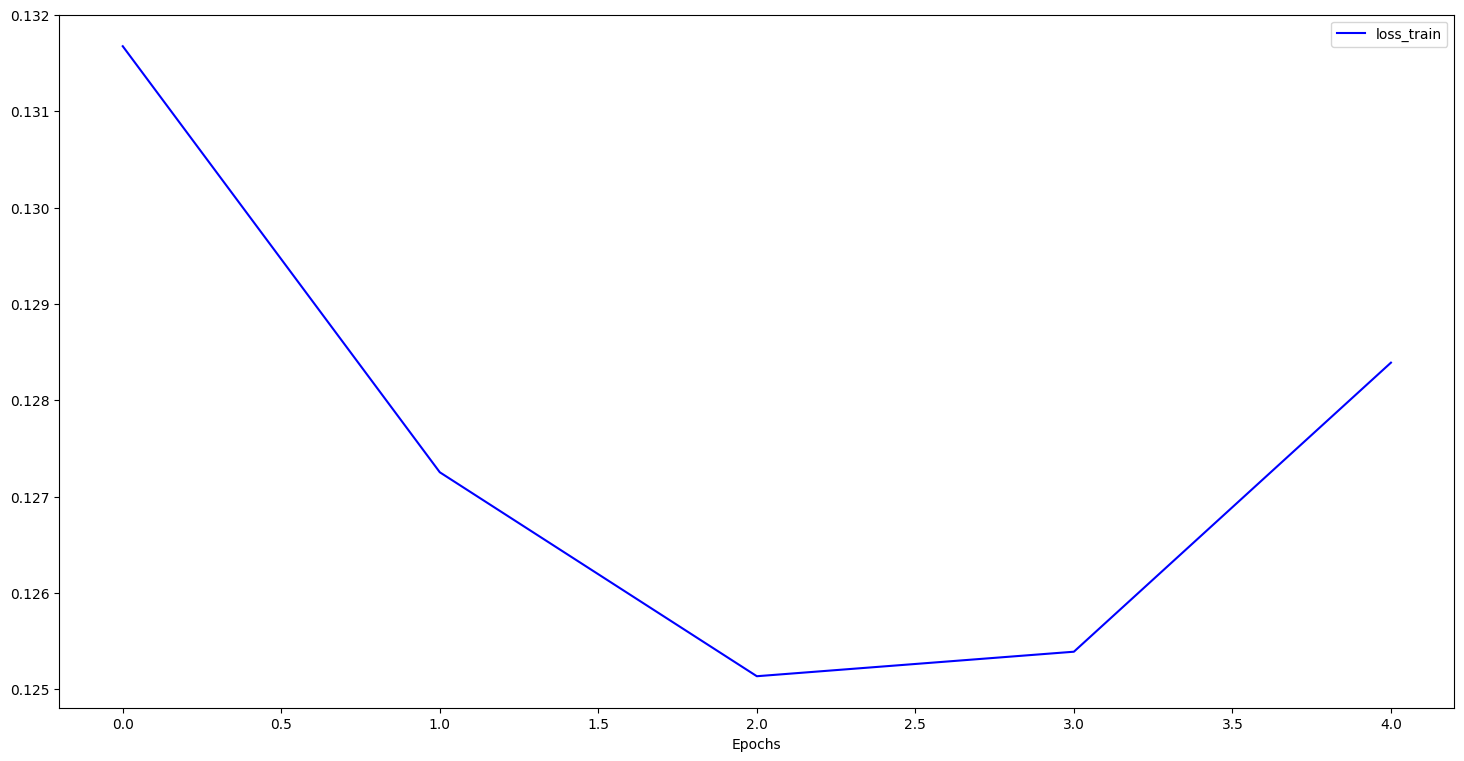

In [11]:
if allow_train:
    helper_functions.plot_loss_curves_post_train(train_results)

In [12]:
test_results = engine_post_train.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

f1_score_per_class: tensor([0.9251, 0.4589, 0.7252, 0.2857, 0.5041])
f1_score_macro (unweighted average): 0.589593768119812
test acc: 0.7699404761904762
QWK score: 0.8577624559402466


In [13]:
test_results = engine_post_train.test_step(model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            device=device)

f1_score_per_class: tensor([0.9848, 0.8807, 0.9342, 0.8500, 0.8617])
f1_score_macro (unweighted average): 0.9022598266601562
test acc: 0.945777027027027
QWK score: 0.9698810577392578
